In [8]:
import pickle
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from umap import UMAP
from pathlib import Path
from typing import Dict

In [2]:
def read_pickle(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f)

def flatten_embeddings(emb_dict: Dict[str, np.ndarray]) -> np.ndarray:
    return np.vstack(emb_dict.values())
    
def get_model_name(model_path: Path) -> str:
    return re.match("\w+-\w+-\d+", model_path.name).group()

In [3]:
# Loading data
DATA_DIR = Path("../data")
MODEL_DIR = Path("../models")
model = next(MODEL_DIR.glob("*topic_model"))
model_name = get_model_name(model)
embeddings = np.load(DATA_DIR / f"{model_name}_embs.npy")

In [6]:
umap_model = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine')
umap_embeddings = umap_model.fit_transform(embeddings, None)

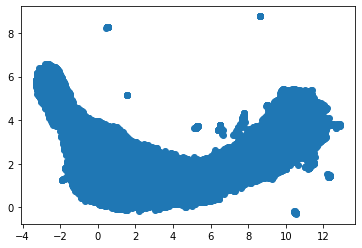

In [9]:
umap_embeddings.shape

plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1])


In [19]:
model.calculate_centroids(doc_topics["topic"], doc_topics["prob"], embeddings)

array([[-0.31369581,  0.14069182,  0.30839828, ...,  0.14768848,
        -0.31350435, -0.07608722],
       [-0.34384449,  0.11415869,  0.30685374, ...,  0.18315915,
        -0.23269803, -0.07757123],
       [-0.34133812,  0.16279837,  0.30273958, ...,  0.1487918 ,
        -0.30827798, -0.04475188],
       [-0.316619  ,  0.09571641,  0.18792396, ...,  0.2236739 ,
        -0.19927784, -0.09734898],
       [-0.52454731,  0.13400279,  0.13540939, ...,  0.43394851,
        -0.15234472, -0.14136522]])

In [34]:
# Transform and remove nan
new_features = model.transform_many(embeddings_dict.values())
new_features = new_features[~np.isnan(new_features).any(axis=1)]

In [37]:
new_features.shape

(7835, 5)

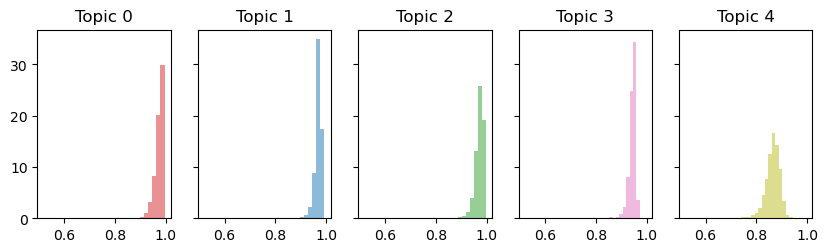

In [43]:
# Visualize this bad boi
from matplotlib import pyplot as plt 
# Plot
fig, axes = plt.subplots(1, 5, figsize=(10,2.5), dpi=100, sharex=True, sharey=True)
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink', 'tab:olive']

for i, ax in enumerate(axes.flatten()):
    ax.hist(new_features[:, i], alpha=0.5, bins=30, density=True, stacked=True, label=i, color=colors[i])
    ax.set_title(f"Topic {i}")